In [473]:
import math
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [474]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [475]:
dl = DataLib("SignalData")

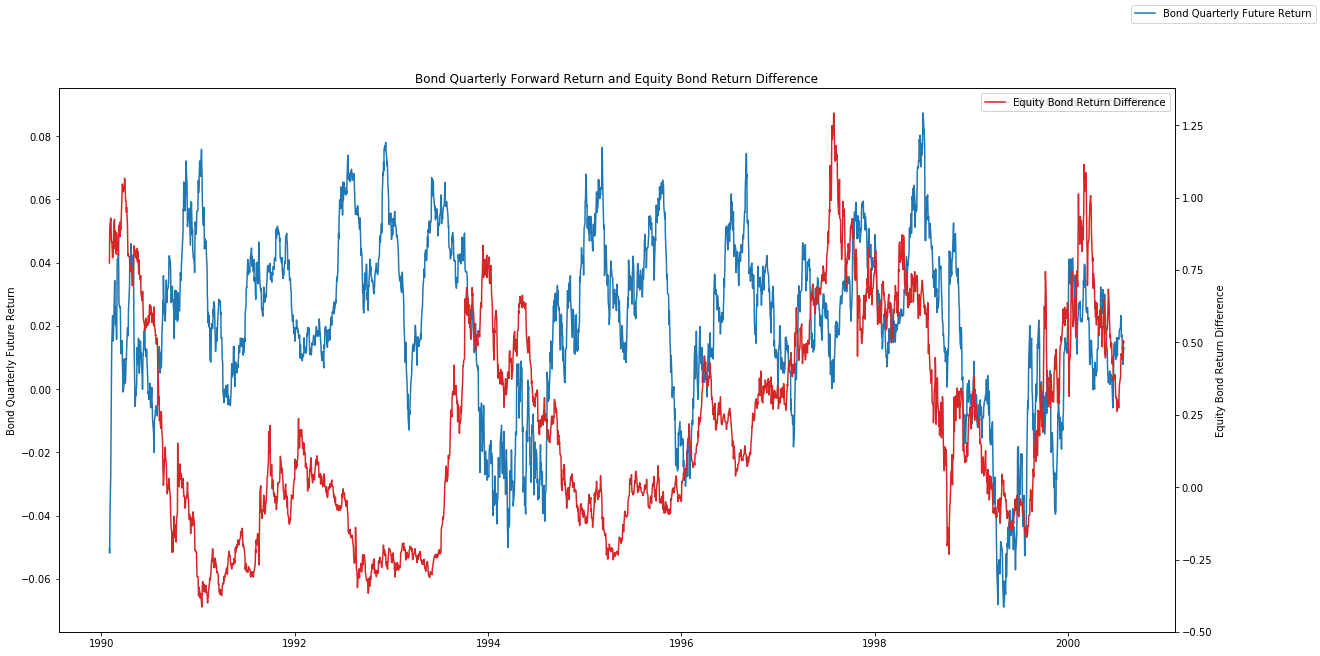

In [505]:
# INDICATOR CONSIDERATION 1

# relative stock and bond performance
# maybe during a time of economic growth, and a differential between stock and bond returns 

WEEKDAYS_IN_YEAR = 261
QUARTER_YEAR = 65
country = 'DEU'
BondsReturns = dl.pull('BondRetIdx/LocalFX')
Equities = dl.pull('EquityPrices')

# GENERATE TO SEE LINKAGE
Bond_semiannual_return = BondsReturns.pct_change(QUARTER_YEAR, fill_method = None)
Bond_semiannual_return = Bond_semiannual_return.shift(-QUARTER_YEAR) # this will be "future returns" (starting today) instead of past returns (starting 6 months ago)

# THIS IS THE YEARLY PERCENT CHANGE IN EQUITY BOND RETURN DIFFERENCE
Equity_Bond_Differential = (Equities - BondReturnIndex).pct_change(WEEKDAYS_IN_YEAR, fill_method = None)



fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax2 = ax1.twinx()
ax1_label = 'Bond Quarterly Future Return'
ax1.plot(Bond_semiannual_return[country].loc[pd.Period('1990-01'):pd.Period('2000-07')].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Equity Bond Return Difference'
ax2.plot(Equity_Bond_Differential[country].loc[pd.Period('1990-01'):pd.Period('2000-07')].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('Bond Quarterly Forward Return and Equity Bond Return Difference')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

# NOTE: THIS NEEDS TO BE FIXED - RIGHT NOW LOSING INFORMATION ABOUT THE GROWTH OF EQUITIES AND BONDS

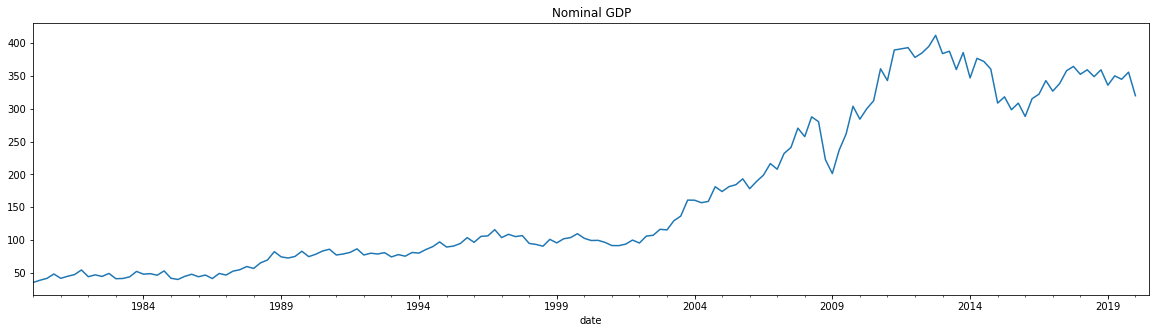

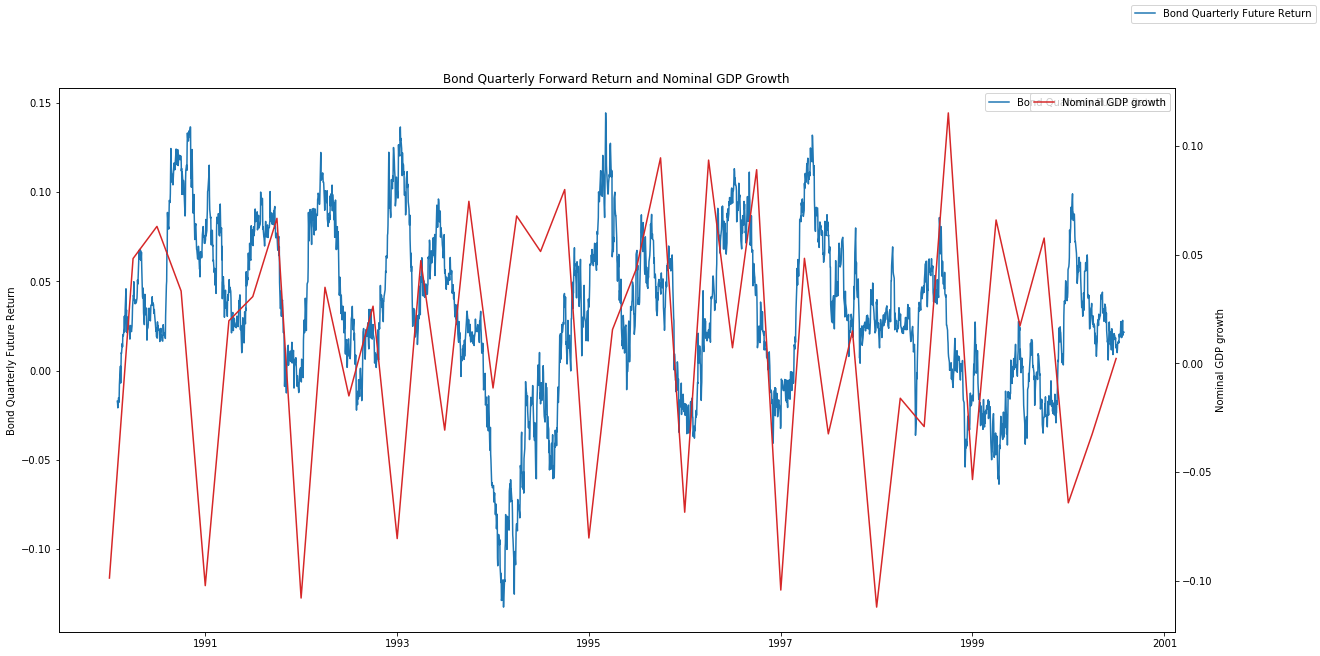

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.014910,0.016664,0.073393,-0.041361,-0.024687,-0.012975,0.013470,0.018147,-0.032877,0.010835
2019Q4,0.031383,0.014272,-0.008102,0.059683,0.038419,0.064624,0.030244,0.001220,0.073438,0.020856
2020Q1,-0.100725,-0.043724,-0.103851,-0.107440,-0.076981,-0.146171,-0.044299,-0.016016,-0.030518,-0.051158
2020Q2,0.000000,-0.098522,0.000000,-0.143829,-0.120075,0.000000,0.000000,0.000000,0.000000,-0.071803
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [506]:
# INDICATOR 2 GDP Growth Nominal (to get inflation)

QUARTER_YEAR = 65
country = 'AUS'
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')

# GENERATE TO SEE LINKAGE
Bond_semiannual_return = BondReturnIndex.pct_change(QUARTER_YEAR, fill_method = None)
Bond_semiannual_return = Bond_semiannual_return.shift(-QUARTER_YEAR) # this will be "future returns" (starting today) instead of past returns (starting 6 months ago)


gdpNom = dl.pull("GDP/Nominal")

# graph of the GDP
plt.figure(figsize=(20,5))
gdpNom[country].plot()
plt.title('Nominal GDP')
plt.show()

# graph of the GDP growth vs. future quarter bond returns
ngdp_growth = gdpNom.pct_change()

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax2 = ax1.twinx()
ax1_label = 'Bond Quarterly Future Return'
ax1.plot(Bond_semiannual_return[country].loc[pd.Period('1990-01'):pd.Period('2000-07')].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Nominal GDP growth'
ax2.plot(ngdp_growth[country].loc[pd.Period('1990-01'):pd.Period('2000-07')].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('Bond Quarterly Forward Return and Nominal GDP Growth')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

ngdp_growth.tail()

In [507]:
# INDICATOR 3

In [508]:
# SIGNAL CREATION FUNCTION

# This is a function that takes in three data streams and produces a signal for each date
# Assume that each data stream is for one country only (call this function for each country if multiple countries)
# Returns a vector that is a signal x in [-1,1] for each date where x is a position for the next day

def generate_signal(country_data_1, country_data_2 = None, country_data_3 = None):
    # copy the dates over from the data
    country_data_1_no_na = country_data_1.copy().dropna()
    
    # create a signals dataframe, fill with 0
    signals = country_data_1.copy().dropna()
    signals[signals != 0] = 0
    
    if country_data_1_no_na[0] > 0:
        signals[0] = -1
    else:
        signals[0] = 1

    skip_first = True
    for date, row in country_data_1_no_na.iteritems():
        # skip the first to avoid out of bounds error
        if skip_first:
            skip_first = False
            continue
        
        today_change = country_data_1_no_na[date]
        yesterday_change = country_data_1_no_na[date - BDay(1)]
        diff = today_change - yesterday_change
        
        # go short if the annual rate of equity-bond return increases and equity-bond return rate is >0.1
        # that is, equity bond return difference had grown and IS growing, signifies opportunity cost
        if today_change > 0.5:
            signals[date] = -1
        else:
            signals[date] = 1
    
    return signals

    

In [509]:
# TEST RETURNS

def test_returns(country, signal):
    BondReturns = dl.pull('BondRetIdx/LocalFX')
    
    earliest_date = signal.index.min()
    latest_date = signal.index.max()
    
    lagged_bond_returns = BondReturns[country].pct_change().shift(-1)[earliest_date:]
    daily_returns =  lagged_bond_returns * signal
    
    sum_our_returns = daily_returns.cumsum()
    sum_bond_returns = lagged_bond_returns.cumsum()
    
    plt.figure(figsize=(20,5))
    sum_our_returns.plot()
    sum_bond_returns.plot()
    plt.title('Cummulative Returns')
    plt.legend(['Our ' + country + ' Cummulative Returns', country + ' Cummulative Bond Returns'])
    plt.show()
    
    print('Active Money Made: ' + str(sum_our_returns[latest_date - BDay(1)]))
    print('Passive Money Made: ' + str(sum_bond_returns[latest_date - BDay(1)]))
    
def show_signals(signal):
    plt.figure(figsize=(20,1))
    signal.plot()
    plt.title('Signals Over Time')
    plt.show()


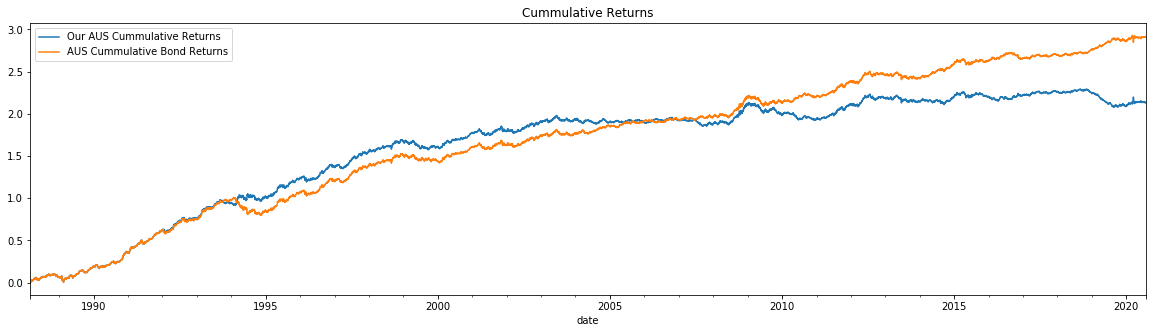

Active Money Made: 2.1301738443789286
Passive Money Made: 2.9146674116751585


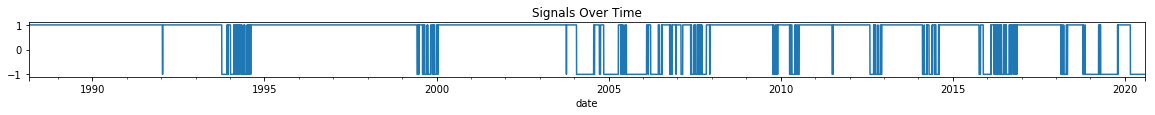

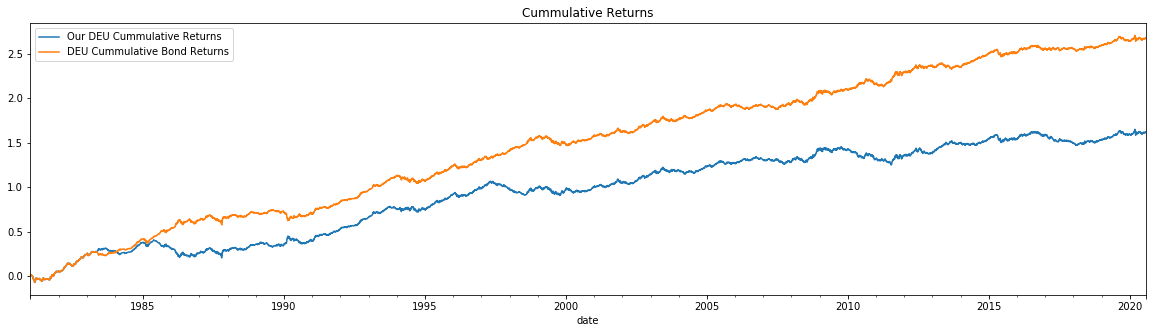

Active Money Made: 1.6219979993629405
Passive Money Made: 2.6783961429551106


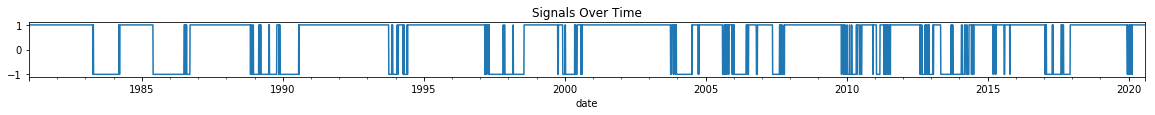

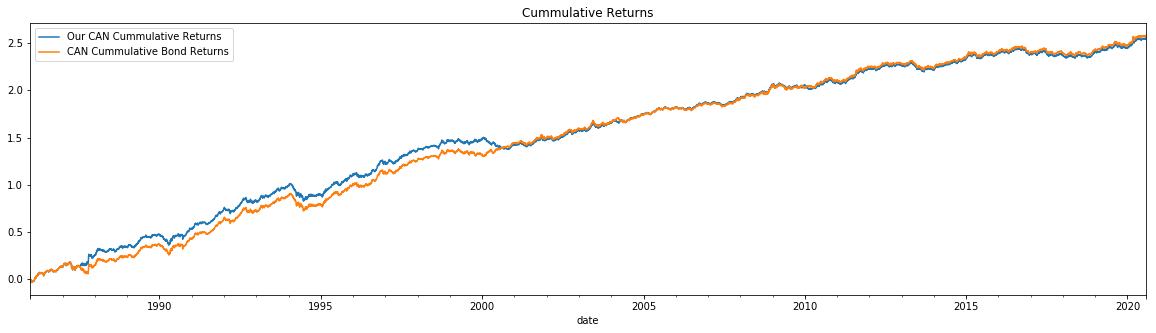

Active Money Made: 2.5538245686976047
Passive Money Made: 2.5801389333259466


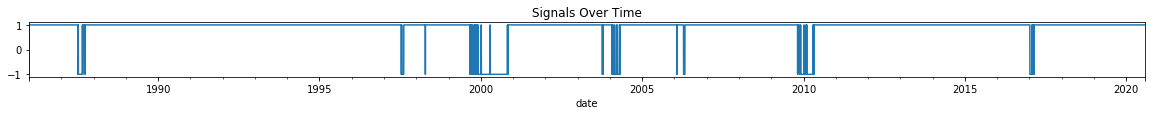

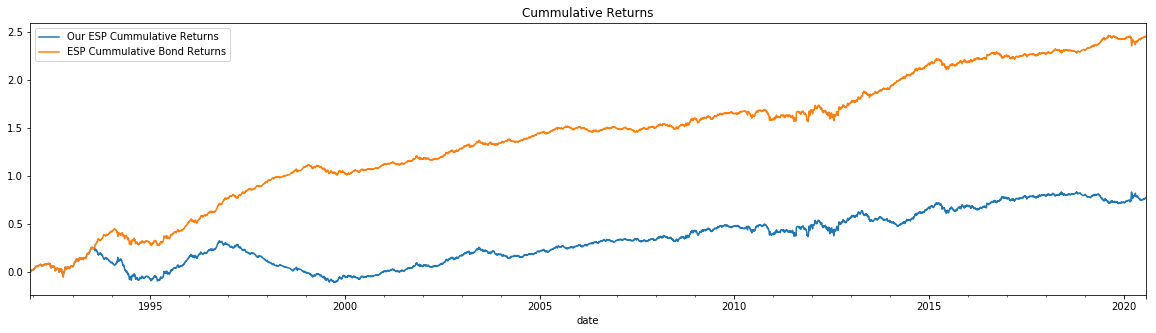

Active Money Made: 0.7710735473979937
Passive Money Made: 2.454890417164777


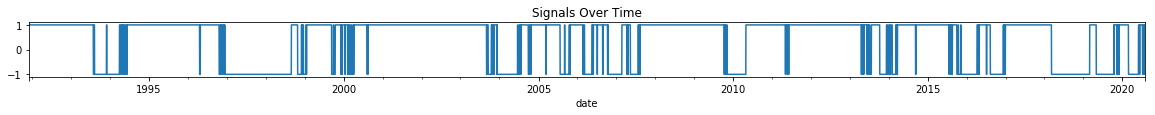

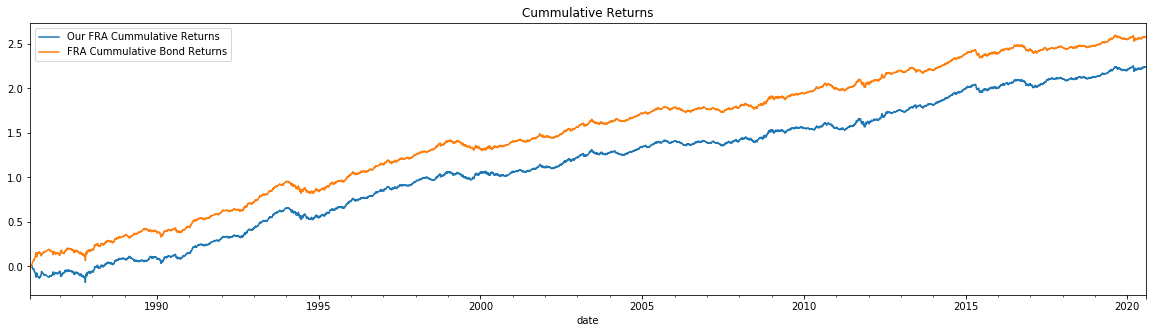

Active Money Made: 2.242072003614501
Passive Money Made: 2.5819312373306857


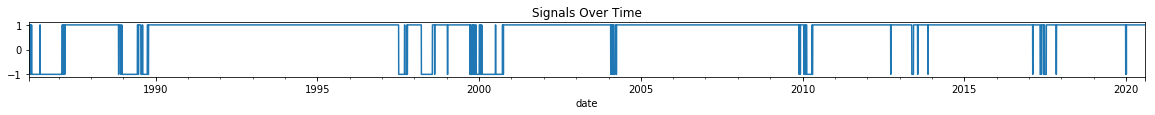

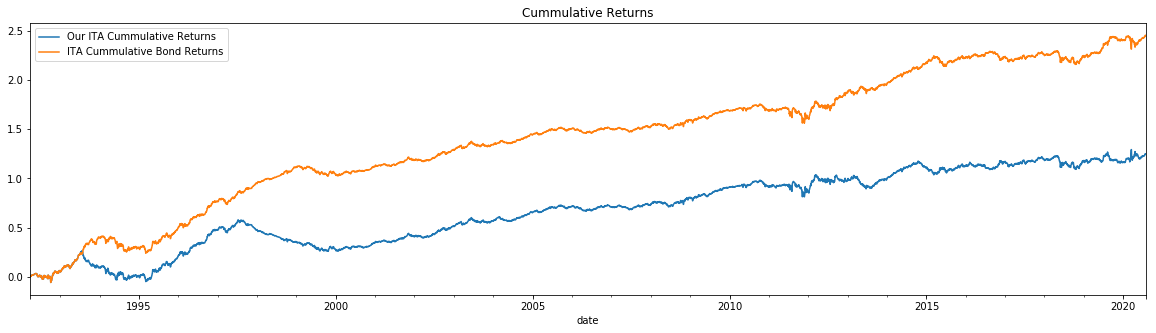

Active Money Made: 1.2463230752592165
Passive Money Made: 2.4510606352249527


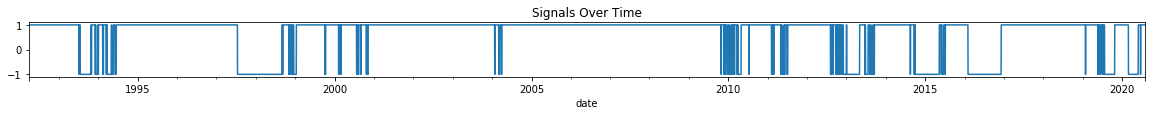

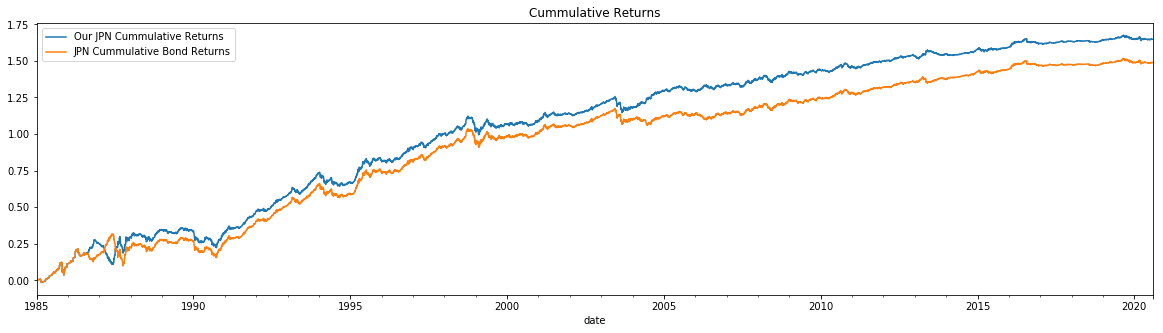

Active Money Made: 1.6485380715302664
Passive Money Made: 1.4890989858384267


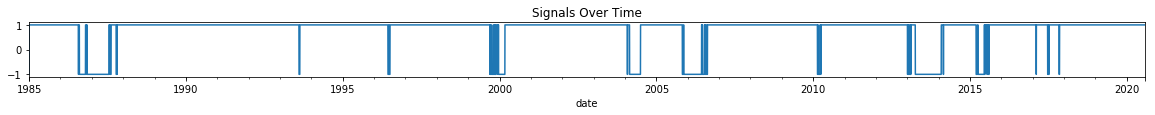

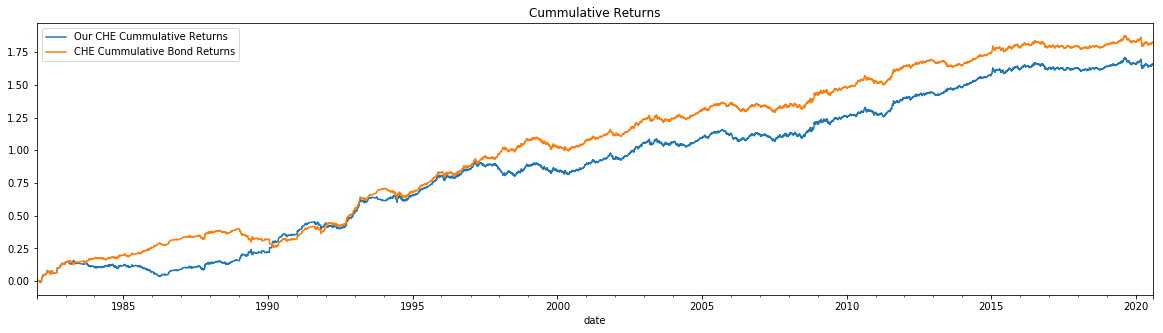

Active Money Made: 1.6583850469812158
Passive Money Made: 1.8264942821172965


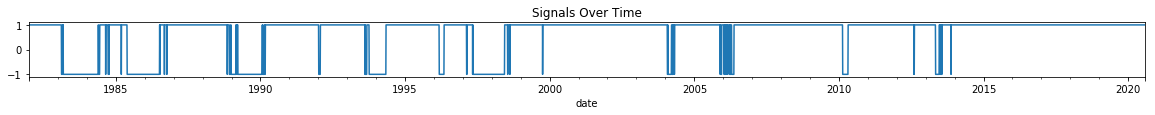

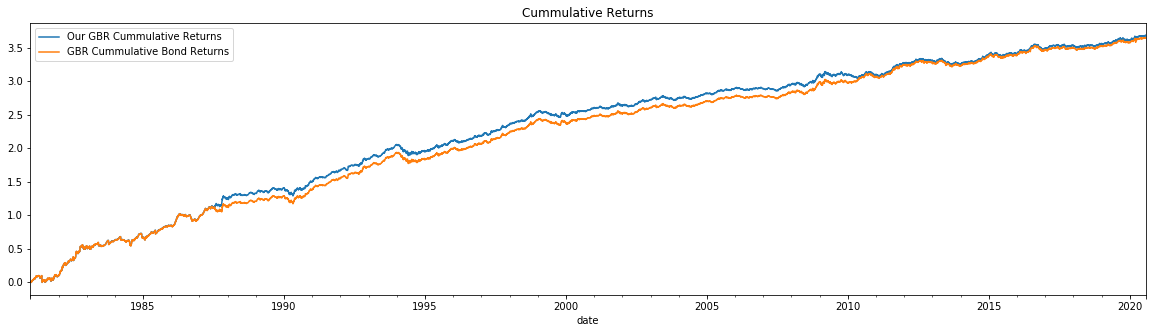

Active Money Made: 3.679959892603583
Passive Money Made: 3.645468552045155


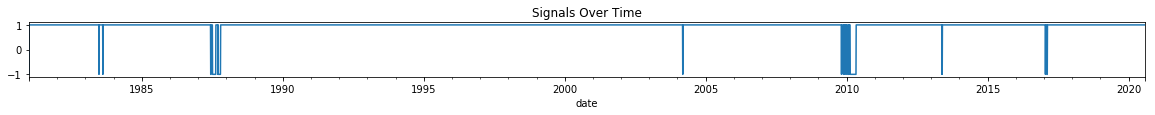

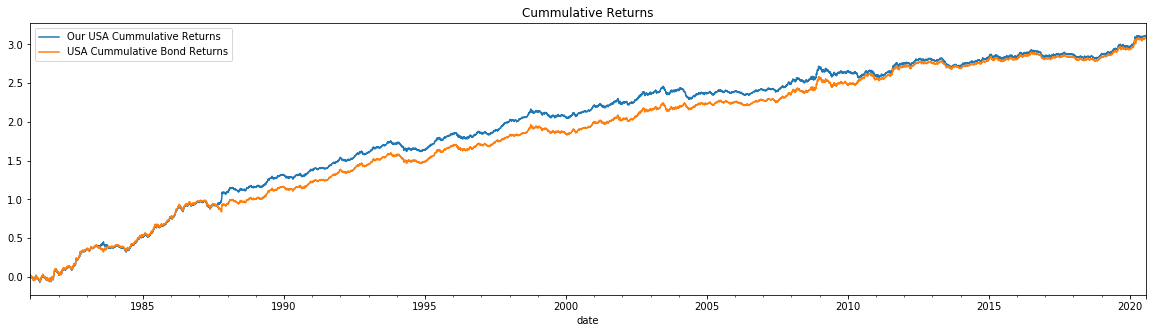

Active Money Made: 3.117425610318614
Passive Money Made: 3.0850757280303425


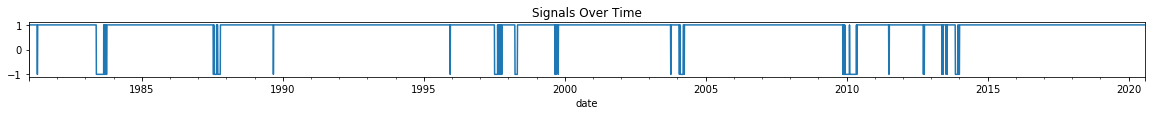

In [510]:
# SEE RESULTS

all_countries = ['AUS','DEU','CAN','ESP','FRA','ITA','JPN','CHE','GBR','USA']

for country in all_countries:
    indicator_1 = Equity_Bond_Differential[country]
    indicator_2 = ngdp_growth[country]
#     signal = generate_signal(indicator_1)
    signal = generate_signal_2(indicator_1, indicator_2)
    test_returns(country, signal)
    show_signals(signal)
    